In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport models

# Xin Chen's implementation of the MBE-NN network

* Author: Xin Chen
* Email: Bismarrck@me.com

This jupyter notebook is used to repeat the work of http://doi.org/10.1021/acs.jctc.6b00994. 

The test cluster is $\textrm{C}_{9}\textrm{H}_{7}\textrm{N}$. The reference energies are calculated with DFTB.

<img src="./C9H7N.png" alt="network" style="width: 600px;"/>

## 1. Overview

The structure of the deep convolutional neural network for the $Pt_{13}$ cluster is as follows:

<img src="./convnet.jpg" alt="network" style="width: 800px;"/>

The input features are transformed interatomic distances. The output node represents the estimated DFT energies.
The detailed explanantion of this convolutionary neural network will be given in the following section **Inference**.

## 2. Declarations

In this section we shall import python modules and declare global constants.

In [2]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import re
import h5py
import sys
import time
import hashlib
import shutil
from datetime import datetime
from fnmatch import fnmatch
from itertools import repeat
from os.path import isfile, isdir, join, basename, splitext
from os import makedirs, listdir
from scipy.misc import comb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances, r2_score
from itertools import combinations
from matplotlib import pyplot as plt
from IPython.display import clear_output, Image, display, HTML
from tensorflow.python.framework import constant_op
from tensorflow.python.framework import ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.contrib.learn import ModeKeys
sns.set(font="serif")
plt.rcParams["figure.figsize"] = [15, 12]

In [3]:
# The patch size is always 1x1
PATCH_SIZE = 1

# The HDF5 database file.
HDF5_DATABASE_FILE = "c9h7n.hdf5"

# The dimension of the cluster.
NUM_SITES = 17

# The total number of structures in the XYZ file should be 209660.
XYZ_FILE = "../datasets/C9H7N.xyz"
TOTAL_SIZE = 5000

# Setup the size.
LOAD_SIZE = 5000
TEST_SIZE = 0.2

# Setup the random seed.
SEED = 235

# Setup the precision of floats. 
TF_TYPE = tf.float32
NP_TYPE = np.float32

# Cuda
CUDA_ON = True

# Set this to True to make input features zero-centered.
ZERO_CENTER = False

# The fixed constants: C(N,k) and C(k,2) where k is 4.
CNK = comb(NUM_SITES, 4, exact=True)
CK2 = comb(4, 2, exact=True)

# The pyykko radius (+1) for each element.
pyykko = {
  'Ac': 1.86, 'Ag': 1.28, 'Al': 1.26, 'Am': 1.66, 'Ar': 0.96, 'As': 1.21,
  'At': 1.47, 'Au': 1.24, 'B': 0.85, 'Ba': 1.96, 'Be': 1.02, 'Bh': 1.41,
  'Bi': 1.51, 'Bk': 1.68, 'Br': 1.14, 'C': 0.75, 'Ca': 1.71, 'Cd': 1.36,
  'Ce': 1.63, 'Cf': 1.68, 'Cl': 0.99, 'Cm': 1.66, 'Co': 1.11, 'Cr': 1.22,
  'Cs': 2.32, 'Cu': 1.12, 'Db': 1.49, 'Ds': 1.28, 'Dy': 1.67, 'Er': 1.65,
  'Es': 1.65, 'Eu': 1.68, 'F': 0.64, 'Fe': 1.16, 'Fm': 1.67, 'Fr': 2.23,
  'Ga': 1.24, 'Gd': 1.69, 'Ge': 1.21, 'H': 0.32, 'He': 0.46, 'Hf': 1.52,
  'Hg': 1.33, 'Ho': 1.66, 'Hs': 1.34, 'I': 1.33, 'In': 1.42, 'Ir': 1.22,
  'K': 1.96, 'Kr': 1.17, 'La': 1.8, 'Li': 1.33, 'Lu': 1.62, 'Md': 1.73,
  'Mg': 1.39, 'Mn': 1.19, 'Mo': 1.38, 'Mt': 1.29, 'N': 0.71, 'Na': 1.55,
  'Nb': 1.47, 'Nd': 1.74, 'Ne': 0.67, 'Ni': 1.1, 'No': 1.76, 'Np': 1.71,
  'O': 0.63, 'Os': 1.29, 'P': 1.11, 'Pa': 1.69, 'Pb': 1.44, 'Pd': 1.2,
  'Pm': 1.73, 'Po': 1.45, 'Pr': 1.76, 'Pt': 1.23, 'Pu': 1.72, 'Ra': 2.01,
  'Rb': 2.1, 'Re': 1.31, 'Rf': 1.57, 'Rh': 1.25, 'Rn': 1.42, 'Ru': 1.25,
  'S': 1.03, 'Sb': 1.4, 'Sc': 1.48, 'Se': 1.16, 'Sg': 1.43, 'Si': 1.16,
  'Sm': 1.72, 'Sn': 1.4, 'Sr': 1.85, 'Ta': 1.46, 'Tb': 1.68, 'Tc': 1.28,
  'Te': 1.36, 'Th': 1.75, 'Ti': 1.36, 'Tl': 1.44, 'Tm': 1.64, 'U': 1.7,
  'V': 1.34, 'W': 1.37, 'X': 0.32, 'Xe': 1.31, 'Y': 1.63, 'Yb': 1.7,
  'Zn': 1.18, 'Zr': 1.54
}

The following cell defines the pyykko radii matrix for exponentially scaling interactomic distances. In this $\textrm{C}_{9}\textrm{H}_{7}\textrm{N}$ case, the pyykko bond lengths of C-H, C-N and C-C varys.

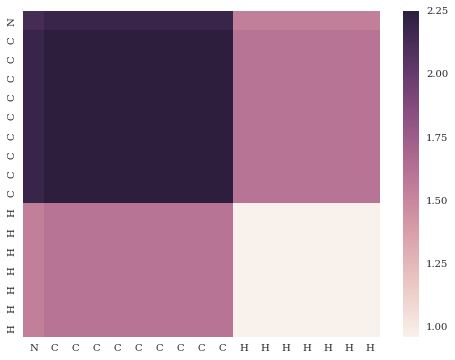

In [4]:
plt.rcParams["figure.figsize"] = [8, 6]
factor = 1.5
pyykko_radii = {"N": 0.71, "C": 0.75, "H": 0.32}
species = ["N"] + list(repeat("C", 9)) + list(repeat("H", 7))
rr = np.asarray([pyykko_radii[specie] for specie in species])[:, np.newaxis]
lmat = factor * (rr + rr.T).flatten()
sns.heatmap(lmat.reshape((17, 17)), xticklabels=species, yticklabels=species)

Some global helper functions are declared here.

In [5]:
def brange(start, stop, batchsize):
  """
  Range from `start` to `stop` given a batch size and return the start and stop of each batch.
  
  Args:
    start: int, the start number of a sequence.
    stop: int, the end number of a sequence.
    batchsize: int, the size of each batch.
  
  """
  istart = start
  while istart < stop:
    istop = min(istart + batchsize, stop)
    yield istart, istop
    istart = istop


def exponential(x, l=4.0):
  """
  Exponentially scale the input value(s).  
  """
  return np.exp(-x / l)


def md5(filename):
  """ 
  Return the md5 checksum of the given file.

  Args:
    filename: a file.

  Returns:
    checksum: the MD5 checksum of the file.

  """
  hash_md5 = hashlib.md5()
  with open(filename, "rb") as f:
    for chunk in iter(lambda: f.read(4096), b""):
      hash_md5.update(chunk)
  return hash_md5.hexdigest()


def root_mean_squred(x):
  """
  Return the root mean squared of the given array.
  """
  return np.sqrt(np.mean(np.square(x)))


def mean_abs_error(y_true, y_pred):
  """
  Return the mean absolute error.
  """
  return np.mean(np.abs(y_true - y_pred))


def get_time_id():
  """
  Return a string as the ID of this run.
  """
  return datetime.strftime(datetime.fromtimestamp(time.time()), "%m%d%H%M")


def get_pyykko_scaling_matrix(species, factor=1.5, flat=True):
  """
  Return the pyykko-bond-length based scaling matrix.
  
  Args:
    species: List[str], a list of species.
  
  """
  rr = np.asarray([pyykko_radii[specie] for specie in species])[:, np.newaxis]
  lmat = factor * (rr + rr.T)
  if flat:
    return lmat.flatten()
  else:
    return lmat


def smooth(x, window_len=11, window='hanning'):
  """
  smooth the data using a window with requested size.

  This method is based on the convolution of a scaled window with the signal.
  The signal is prepared by introducing reflected copies of the signal
  (with the window size) in both ends so that transient parts are minimized
  in the begining and end part of the output signal.

  Args:
    x: the input signal
    window_len: the dimension of the smoothing window; should be an odd integer
    window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman' 
      flat window will produce a moving average smoothing.

  output:
    the smoothed signal
  """

  if x.ndim != 1:
    raise ValueError("smooth only accepts 1 dimension arrays.")

  if x.size < window_len:
    raise ValueError("Input vector needs to be bigger than window size.")

  if window_len < 3:
    return x

  if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
    raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

  s = np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
  if window == 'flat':
    w = np.ones(window_len,'d')
  else:
    w = eval('np.'+ window +'(window_len)')

  return np.convolve(w / w.sum(), s, mode='valid')


dense_patt = re.compile("Dense\d+/kernel.*")

def is_dense_weights(var):
  """
  Return True if the given 'tf.Variable' is the weights matrix of a dense layer.
  """
  return dense_patt.search(var.name) is not None

## 3. Inference

This convnet is a slightly different from normal convolutionary neural networks. Suppose N is the batch size:

* The shape of the input tensor is: $[N, 1, C_{N}^{k}, C_{k}^{2}]$
* The **k** defines the many-body expansion. In this paper, k is selected to be 4.
* The patch (kernel) is always 1x1.
* The padding scheme is 'SAME' and the strides are 1 in both directions.

The ``MBE-NN-M`` model and its variants are implemented in **``model.py``**.

## 4. Preparing the Dataset

### 4.1 Transformation

It is known that Gaussian coordinates are not suitable to direcly used as input of NN. Therefor, two transformations are adapted here on the input sample data in Cartesian coordiantes $\{r_{j}\}$:

1. Transform each set of combination indices $\{j\}$ ($k=4$) to interatomic distances $\{d_{i,j}\}$ ($C_{k}^{2}=6$). 
2. Dump these interatomic distances with the exponential function: $d_{i,j}' = e^{-d_{i,j}/L}$. $L$ is a fixed parameter and 4.0 was used in this paper.

The following figure demonstrates the workflow of these transformations:

<img src="./input_transform.png" alt="Drawing" style="width: 900px;"/>

The shape of the final input matrix should be: [1, $C_{N}^{k}$, $C_{k}^{2}$]

* The width is 1
* The height is $C_{N}^{k}$
* The depth is $C_{k}^{2}$

So that we can use it in a convolutionary neural network!

In [6]:
def transform_coords(coords, chunksize, mapping, l=4.0, verbose=True):
  """
  Transform the cartesian coordinates to input features.

  Args:
    coords: a 3D array with shape [M,N,3] representing the cartesian coordinates.
    chunksize: the transformed array is too large. So save it piece by piece.
    mapping: a `h5py.Dataset`, which is a symbolic to the real data on disk.
    l: the exponential parameter.
    verbose: print the transformation progress if True.

  """
  ntotal, n = coords.shape[:2]
  cnkv = comb(n, 4, exact=True)
  ck2v = comb(4, 2, exact=True)
  cnkl = list(combinations(range(NUM_SITES), 4))
  # Using mapping indices can increase the speed 30 times!
  indices = np.zeros((ck2v, cnkv), dtype=int)
  for i in range(cnkv):
    for j, (vi, vj) in enumerate(combinations(cnkl[i], 2)):
      indices[j, i] = vi * n + vj
  dataset = np.zeros((chunksize, 1, cnkv, ck2v), dtype=NP_TYPE)
  tic = time.time()
  if verbose:
    print("Transform the cartesian coordinates ...\n")
  for i, inext in brange(0, ntotal, chunksize):
    for j in range(i, inext):
      dists = pairwise_distances(coords[j]).flatten()
      dists = exponential(dists, l=l)
      for k in range(ck2v):
        dataset[j - i, 0, :, k] = dists[indices[k]]
      del dists
    batch_size = inext - i
    mapping[i: inext, ...] = dataset[:batch_size, ...]
    if verbose:
      sys.stdout.write("\rProgress: %7d  /  %7d" % (inext, ntotal))
    dataset.fill(0.0)
  del indices
  del dataset
  if verbose:
    print("")
    print("Total time: %.3f s\n" % (time.time() - tic))

### 4.2 Parsing

Extract the XYZ coordinates and atomic symbols from the raw file. The raw file is not a standard XYZ file, so we need to write a helper function to do this.

In [7]:
def extract_xyz(filename, verbose=True):
  """
  Extract symbols, coordiantes and forces (for later usage) from the raw file.
  
  Args:
    filename: a str.
    verbose: a bool.

  Returns
    energies: Array[N,]
    coordinates: Array[N, 17, 3], a 3D array containing the atomic coordinates.
    forces: Array[N, 17, 3], a 3D array containing the atomic forces.
  
  """
  group = "raw"
  hdb = h5py.File(HDF5_DATABASE_FILE)
  if group not in hdb:
    hdb.create_group(group)
  
  try:
    energies = hdb[group]["energies"][:]
    coordinates = hdb[group]["coordinates"][:]
    forces = hdb[group]["forces"][:]

  except Exception:
    energies = np.zeros((TOTAL_SIZE,), dtype=NP_TYPE)
    coordinates = np.zeros((TOTAL_SIZE, NUM_SITES, 3), dtype=NP_TYPE)
    forces = np.zeros((TOTAL_SIZE, NUM_SITES, 3), dtype=NP_TYPE)
    stage = 0
    i = 0
    j = 0
    energy_patt = re.compile(r".*energy=([\d.-]+).*")
    string_patt = re.compile(r"([A-Za-z]{1,2})\s+([\d.-]+)\s+([\d.-]+)\s+([\d.-]+)\s+"
                              "\d+\s+\d.\d+\s+\d+\s+([\d.-]+)\s+([\d.-]+)\s+([\d.-]+)")
    tic = time.time()
    if verbose:
      sys.stdout.write("Extract cartesian coordinates ...\n")
    with open(filename) as f:
      for line in f:
        if i == TOTAL_SIZE:
          break
        l = line.strip()
        if l == "":
          continue
        if stage == 0:
          if l.isdigit():
            n = int(l)
            if n != NUM_SITES:
              raise ValueError("The parsed size %d != NUM_SITES" % n)
            stage += 1
        elif stage == 1:
          m = energy_patt.search(l)
          if m:
            energies[i] = float(m.group(1))
            stage += 1
        elif stage == 2:
          m = string_patt.search(l)
          if m:
            coordinates[i, j, :] = float(m.group(2)), float(m.group(3)), float(m.group(4))
            forces[i, j, :] = float(m.group(5)), float(m.group(6)), float(m.group(7))
            j += 1
            if j == NUM_SITES:
              j = 0
              stage = 0
              i += 1
              if verbose and i % 1000 == 0:
                sys.stdout.write("\rProgress: %7d  /  %7d" % (i, TOTAL_SIZE))
      if verbose:
        print("")
        print("Total time: %.3f s\n" % (time.time() - tic))
      hdb[group].create_dataset("energies", data=energies)
      hdb[group].create_dataset("coordinates", data=coordinates)
      hdb[group].create_dataset("forces", data=forces)
  
  finally:
    hdb.close()
  
  return energies, coordinates, forces

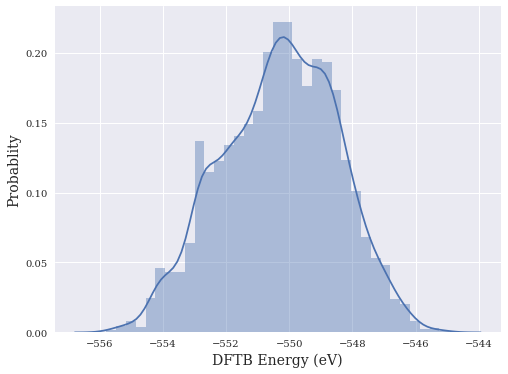

In [8]:
energies, coordinates, _ = extract_xyz(XYZ_FILE)
ax = sns.distplot(energies)
ax.set_xlabel("DFTB Energy (eV)", fontsize=14)
ax.set_ylabel("Probablity", fontsize=14)

### 4.3 Building

Build the dataset and split it into training, validation and testing datasets:

1. Initialize a new hdf5 file if it can not be accessed.
1. Extract symbols, energies, atomic coordinates and forces from the file.
2. Transform and scale the coordinates to build the 4D array $[N, 1, C_{N}^{k}, C_{k}^{2}]$.

**Warning: in this case ($\textrm{C}_{9}\textrm{H}_{7}\textrm{N}$), all samples are considered unique!**

In [9]:
def may_build_dataset(filename, l=4.0, verbose=True):
  """
  Build the training, validation and testing dataset and targets from a XYZ file.

  Args:
    filename: str, a file with CP2K/XYZ format.
    l: float, the exponential parameter.
    verbose: bool, print the building progress if True.

  Returns:
    features: a 4D array as the transformed input features.
    targets: a 2D array as the scaled ([0, 1]) targets.
    scaler: a ``sklearn.preprocessing.MinMaxScaler``.

  """
  # Compute the MD5 checksum of the xyzfile
  checksum = md5(filename)

  if verbose:
    print("-> Load the training, validation and testing datasets ...\n")

  coords, energies = None, None
  features, targets = None, None
  backup_hdf5 = False
  extract_coords = True
  build_features = True

  # If the HDF5 file is already existed, we try to load dataset and targets from
  # the HDF5 file directly if the checksums are equal.
  if isfile(HDF5_DATABASE_FILE):
    with h5py.File(HDF5_DATABASE_FILE, "r") as hdb:
      if hdb.attrs.get("checksum", 0) == checksum:
        # There are two main groups in this HDF5 file:
        # 1. the first group is 'train' where training data and training targets
        # are stored.
        if "train" in hdb:
          features = hdb["train"]["dataset"][:LOAD_SIZE]
          targets = hdb["train"]["targets"][:LOAD_SIZE]
          build_features = False
          extract_coords = False
        # 2. the second group is 'unique' where uniquified cartesian coordinates
        # and their energies extracted from a CP2K/XYZ file are saved.
        elif "unique" in hdb.keys():
          coords = hdb["unique"]["coords"][:]
          energies = hdb["unique"]["energies"][:]
          extract_coords = False
      # The checksum are not equal, so we backup the existed HDF5 databse by
      # renaming it.
      else:
        backup_hdf5 = True
    if backup_hdf5:
      if verbose:
        print("MD5 checksums mismatched. Build a new dataset.\n")
      shutil.move(HDF5_DATABASE_FILE, HDF5_DATABASE_FILE + ".bak")

  # Extract the raw cartesian coordinates and energis (eV) from the CP2K/XYZ
  # file and save these data into group 'raw'. All data are compressed with the
  # lossless gzip filter.
  if extract_coords:
    energies, coords, _ = extract_xyz(filename, verbose=verbose)
    # Remove the duplicates to reduce the dataset
    # coords, energies = remove_duplicates(coords, energies, verbose=verbose)
    with h5py.File(HDF5_DATABASE_FILE) as hdb:
      # Delete the previous group `unique`. This should not happen, but it may
      # be inserted manually for debugging.
      group = "unique"
      if group in hdb.keys():
        del hdb[group]
      hdb.attrs["checksum"] = checksum
      hdb.create_group(group)
      hdb[group].create_dataset("coords", data=coords, compression="gzip")
      hdb[group].create_dataset("energies", data=energies, compression="gzip")
  elif verbose:
    print("Use existed coordinates and energies.\n")

  # Transform the cartesian coordinates to a 4D dataset. Permute this dataset
  # several times and then we split it into three parts: training, validation
  # and testing. Save these datasets and their targets into group 'cnn'.
  if build_features:
    # Allocate the disk space and then write transformed data piece by piece
    # because my little computer only has 16GB memory.
    shape = [len(energies), 1, comb(NUM_SITES, 4, True), comb(4, 2, True)]
    hdb = h5py.File(HDF5_DATABASE_FILE)
    try:
      group = hdb.require_group("train")
      group.create_dataset("targets", data=energies)
      mapping = group.create_dataset(
        "dataset", shape=shape, dtype=np.float32)
      # Set the chunksize to 10000.
      chunksize = 10000
      transform_coords(coords, chunksize, mapping, l=l, verbose=verbose)
    except Exception as excp:
      del hdb["train"]
      raise excp
    finally:
      hdb.close()
    # After the transformation we now load the whole dataset into memory.
    with h5py.File(HDF5_DATABASE_FILE) as hdb:
      features = hdb["train"]["dataset"][:LOAD_SIZE]
      targets = np.array(energies[:LOAD_SIZE], copy=False)
    if verbose:
      print("Dataset size (MB)     : ", features.nbytes / 1024 / 1024)
      print("Targets size (MB)     : ", targets.nbytes / 1024 / 1024)
      print("")
    del coords
  elif verbose:
    print("Use existed features and targets.\n")

  # Determine the maximum and minimum energy. The energies should be scaled to
  # [0, 1] during training.
  scaler = MinMaxScaler()
  targets = scaler.fit_transform(np.atleast_2d(targets).T)

  if verbose:
    print("-> Datasets and targets are loaded into memories.")
    print("")
  return features, targets, scaler

In [10]:
features, targets, scaler = may_build_dataset(XYZ_FILE, l=lmat)

-> Load the training, validation and testing datasets ...

Use existed coordinates and energies.

Use existed features and targets.

-> Datasets and targets are loaded into memories.



### 4.4 Preprocessing

In this section further data preprocessing procedures will be taken. See http://cs231n.github.io/neural-networks-2/#batchnorm for explanantions.

Before preprocessing, let's first demonstrate the value distributions of the features:

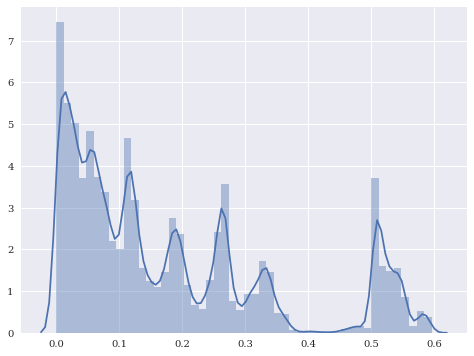

In [11]:
sns.distplot(features.flatten()[::20])

Then, before we start training, the dataset should also be splited. ``sklearn.model_selection.train_test_split`` can be used to achieve this. Remember to set the random state!

Some important notes:

1. **In practice: ** it is very important to zero-center the data.
2. **Common pitfall: ** An important point to make about the preprocessing is that any preprocessing statistics (e.g. the data mean) must only be computed on the training data, and then applied to the validation / test data. E.g. computing the mean and subtracting it from every image across the entire dataset and then splitting the data into train/val/test splits would be a mistake. Instead, the mean must be computed only over the training data and then subtracted equally from all splits (train/val/test).


In [12]:
# Split the datatset into training and testing datasets.
X_train, X_test, y_train, y_test = train_test_split(
  features, 
  targets, 
  random_state=SEED, 
  test_size=TEST_SIZE
)

# Further split the training dataset into training and validation datasets.
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=SEED, test_size=0.1)

# Make the data zero-centered.
if ZERO_CENTER:
  mean = X_train.mean()
  X_train -= mean
  X_test -= mean

Display the value distributions of ``X_train`` and ``X_test``.

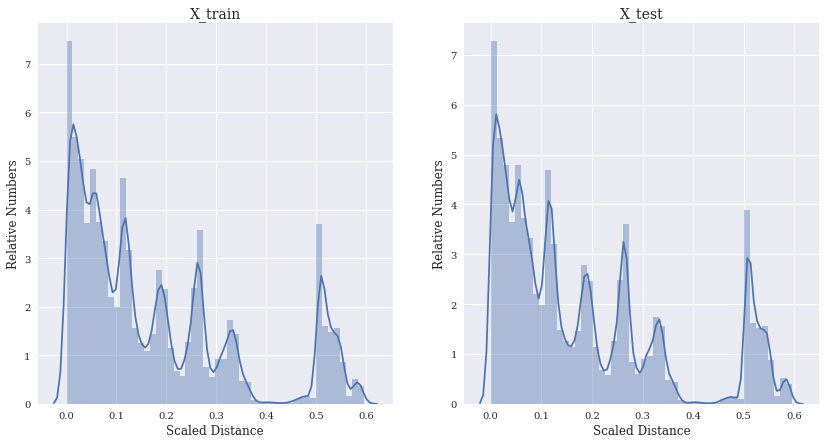

In [13]:
fig, axes = plt.subplots(1, 2, figsize=[14, 7])

ax = sns.distplot(X_train.flatten()[::20], ax=axes[0])
ax.set_xlabel("Scaled Distance", fontsize=12)
ax.set_ylabel("Relative Numbers", fontsize=12)
ax.set_title("X_train", fontsize=14)

ax = sns.distplot(X_test.flatten()[::2], ax=axes[1])
ax.set_xlabel("Scaled Distance", fontsize=12)
ax.set_ylabel("Relative Numbers", fontsize=12)
ax.set_title("X_test", fontsize=14)

## 5. Training

Now we can start training this network. The training settings defined in this paper are summerized here:

* Root-mean-squared loss.
* Mini-batch stochastic gradient descent with momentum
     * Batch size: 50.
     * Momentum factor: 0.7.
* Step Decay Function: $s_{i} = s_{0}r/(r + i)$
     * $s_0$ is the initial step length, which is 0.1 in this paper.
     * r is a predefined factor and r = 60 in this paper.
* Regularization factor is not mentioned in this paper.
     * $\lambda$ is set to None.
* The exponentia ldecay rate is 0.9 in this implementaion.
* The total number of epochs for the reference dataset is 1400.

These parameters are declared in the following section:

In [14]:
batch_size = 50
momentum_factor = 0.7
start_learning_rate = 0.1
decay_rate = 0.9
decay_factor = 100
rlambda = 1e-4

### 5.1 Setup

Invoke the interactive session.

In [15]:
tf.reset_default_graph()
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)

Now we can begin the training. Initialize a new ``graph`` and use it as the default graph. Then we get the infered network.

In [16]:
X_batch = tf.placeholder(TF_TYPE, [batch_size, 1, CNK, CK2], name="X_batch")
y_batch = tf.placeholder(TF_TYPE, [batch_size, 1], name="y_batch")
keep_prob = tf.placeholder(TF_TYPE, name="keep_prob")
dense_keep_prob = tf.placeholder(TF_TYPE, name="dense_keep_prob")

y_pred = models.inference(
  X_batch, 
  "mbe-nn-m-fc", 
  conv_keep_prob=keep_prob, 
  dense_keep_prob=dense_keep_prob, 
  dropouts=[2, 6], 
  dense_dims=[100, 100], 
  conv_dims=[40, 70, 60, 2, 300, 100],
  verbose=True
)

-> Inference the MBE-NN-M-FC model ...

Conv1/Tanh            : [     50,      1,   2380,     40]
Conv2/Tanh            : [     50,      1,   2380,     70]
Conv3/Tanh            : [     50,      1,   2380,     60]
Conv4/Softplus        : [     50,      1,   2380,      2]
Conv5/Softplus        : [     50,      1,   2380,    300]
Conv6/Softplus        : [     50,      1,   2380,    100]
Flatten/Reshape       : [     50, 238000]
Dense7/Relu           : [     50,    100]
Dense8/Relu           : [     50,    100]
Dense9/MatMul         : [     50,      1]


Output the total number of trainable parameters.

In [17]:
total_parameters = 0
for variable in tf.trainable_variables():
  shape = variable.get_shape()
  variable_parameters = 1
  for dim in shape:
    variable_parameters *= dim.value
  total_parameters += variable_parameters
print("Total number of trainable parameters: %d" % total_parameters)

Total number of trainable parameters: 23848832


Add helper functions to visualize the graph. These codes are copied from the official example **deepdream**. Uncomment the last line can display the network graph inline.

In [18]:
def strip_consts(graph_def, max_const_size=32):
  """
  Strip large constant values from graph_def.
  """
  strip_def = tf.GraphDef()
  for n0 in graph_def.node:
    n = strip_def.node.add() 
    n.MergeFrom(n0)
    if n.op == 'Const':
      tensor = n.attr['value'].tensor
      size = len(tensor.tensor_content)
      if size > max_const_size:
        tensor.tensor_content = "<stripped %d bytes>"%size
  return strip_def

def show_graph(graph_def, max_const_size=32):
  """
  Visualize TensorFlow graph.
  """
  if hasattr(graph_def, 'as_graph_def'):
    graph_def = graph_def.as_graph_def()
  strip_def = strip_consts(graph_def, max_const_size=max_const_size)
  code = """
    <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
    <script>
      function load() {{
        document.getElementById("{id}").pbtxt = {data};
      }}
    </script>
    <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
    <div style="height:600px">
    <tf-graph-basic id="{id}"></tf-graph-basic>
    </div>
  """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  iframe = """
    <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
  """.format(code.replace('"', '&quot;'))
  display(HTML(iframe))

# Uncomment the following line to visualize the graph in this notebook. 
# show_graph(graph.as_graph_def())

Setup the total loss. Add L2 loss for the weights of dense layers.

In [19]:
weights = [v for v in tf.trainable_variables() if is_dense_weights(v)]
if len(weights) > 0 and rlambda is not None:
  
  def _nameit(_w):
    return "%sL2" % _w.name.split("/")[0]
  
  with tf.name_scope("regularizer"):
    l2 = tf.multiply(
      tf.add_n([tf.nn.l2_loss(w, name=_nameit(w)) for w in weights]), rlambda)
    tf.summary.scalar("l2", l2)
else:
  l2 = 0.0

with tf.name_scope("loss"):
  rms = tf.sqrt(tf.losses.mean_squared_error(y_pred, y_batch))
  loss = rms + l2
  tf.summary.scalar("rms", rms)
  tf.summary.scalar("loss", loss)

Setup the learning rate decay and the momentum optimizer. The learning rate $r_i$ computed by the inverse decay function in this paper is implemented here:
$$r_{i} = \frac{rs_{0}}{r + i}$$
where $i$ is the epoch, $r$ is a constant decay factor and $s_0$ is the initial learning rate. $r$ is set to 60 in this case.

In [20]:
def inverse_decay(init_learning_rate, epoch, decay_factor, name=None):
  """
  The inverse decay function.
  
  Args:
    init_learning_rate: A scalar `float32` or `float64` `Tensor` or a
      Python number.  The initial learning rate.
    global_epoch: A scalar `int32` or `int64` `Tensor` or a Python number.
      Global epoch to use for the decay computation.  Must not be negative.
    decay_factor: A scalar `int32` or `int64` `Tensor` or a Python number.
      Must be positive.  See the decay equation above.
    name: String.  Optional name of the operation.  Defaults to
      'ExponentialDecay'.

  Returns:
    A scalar `Tensor` of the same type as `learning_rate`.  The decayed
    learning rate.
  
  """
  if epoch is None:
    raise ValueError("global_step is required for inv_decay.")
  with ops.name_scope(name, "InvDecay", 
                      [init_learning_rate, epoch, decay_factor]) as name:
    init_learning_rate = ops.convert_to_tensor(
      init_learning_rate, name="init_learning_rate")
    dtype = init_learning_rate.dtype
    epoch = math_ops.cast(epoch, dtype)
    decay_factor = math_ops.cast(decay_factor, dtype)
    top = math_ops.multiply(init_learning_rate, decay_factor)
    return math_ops.div(top, math_ops.add(epoch, decay_factor), name=name)

In [21]:
global_epoch = tf.Variable(0, dtype=tf.int64, trainable=False, name="global_epoch")
global_epoch_op = tf.assign(global_epoch, global_epoch + 1)
learning_rate = inverse_decay(start_learning_rate, global_epoch, decay_factor)
tf.summary.scalar("learning_rate", learning_rate)

batch = tf.Variable(0, dtype=tf.int64, trainable=False)

# learning_rate = tf.train.exponential_decay(
#   start_learning_rate, 
#   tf.multiply(batch, batch_size), 
#   len(X_train), 
#   decay_rate,
# )
# Test the Adagrad optimzier
# trainer = tf.train.AdagradDAOptimizer(
#   learning_rate=learning_rate, 
#   initial_gradient_squared_accumulator_value=0.1,
#   global_step=batch
# )

# Use the Momentum optimizer
trainer = tf.train.MomentumOptimizer(learning_rate, momentum_factor)
optimizer = trainer.minimize(loss, global_step=batch)

# Merge all the summaries.
merged = tf.summary.merge_all()
writer = tf.summary.FileWriter(logdir="./events/%s" % get_time_id(), graph=graph)

### 5.2 Training

These variabls control the key settings of a training.

In [22]:
num_epochs = 200
log_frequency = 50
eval_frequency = 200
save_frequency = 2000

Setup the saving path and the checkpoint file so that we can reuse this model later.

In [23]:
save_path = "./saves"
chk_file = join(save_path, "c9h7n.ckpt")
if not isdir(save_path):
  makedirs(save_path)

Small utility function to evaluate a dataset by feeding batches of data to ``{eval_dataset}`` and pulling the results 
from ``{eval_values}``. Saves memory and enables this to run on smaller GPUs.

In [24]:
def eval_in_batches(data):
  """ Get all predictions for a dataset by running it in small batches. """
  size = data.shape[0]
  if size < batch_size:
    raise ValueError("batch size for evals larger than dataset: %d" % size)
  eval_values = np.ndarray(shape=(size, 1), dtype=NP_TYPE)
  for i, inext in brange(0, size, batch_size):
    eval_values[i: inext] = sess.run(
      y_pred,
      feed_dict={X_batch: data[i: inext, ...], keep_prob: 1.0, dense_keep_prob: 1.0})
  return eval_values

This helper function is used to restore the latest checkpoint if existed.

In [ ]:
def restore_latest_from_ckpt(save_dir):
  """
  Restore the latest checkpoint from the 'scratch' if possible.
  """
  if not isdir(save_dir):
    return None
  ckpt = tf.train.get_checkpoint_state(save_dir)
  if ckpt and ckpt.model_checkpoint_path:
    return ckpt.model_checkpoint_path

Finally we invoke a new session and start this training.

In [ ]:
# Build an initialization operation.
tf.global_variables_initializer().run()

# Register a model saver
saver = tf.train.Saver()

# Load the previous checkpoint if existed.
checkpoint_path = restore_latest_from_ckpt(save_path)
load = False
if load and checkpoint_path:
  saver.restore(sess, checkpoint_path)
  print("Restore from the lastest checkpoint file %s ..." % checkpoint_path)
  print("")

print("Initialized!")
print("")
print("Training Samples      :", len(X_train))
print("Batch Size            :", batch_size)
print("Number of Epochs      :", num_epochs)
print("Log Frequency         :", log_frequency)
print("Eval Frequency        :", eval_frequency)
print("")

# Save the graph
saver.save(sess, save_path=chk_file, global_step=0)

tic = time.time()
tstart = time.time()

# Keep the validation errors locally
valid_hists = []

# Loop through training steps.
for step in range(int(num_epochs * len(X_train)) // batch_size):
  
  # Compute the offset of the current minibatch in the data.
  # The dataset was already shuffled in assignment 1 so we do not need to
  # randomize it.
  offset = (step * batch_size) % (len(X_train) - batch_size)
  batch_dataset = X_train[offset: (offset + batch_size), ...]
  batch_targets = y_train[offset: (offset + batch_size), ...]
  
  # Build the feed dict to feed previous defined placeholders.
  feed_dict = {
    X_batch: batch_dataset, 
    y_batch: batch_targets, 
    keep_prob: 0.7, 
    dense_keep_prob: 0.5
  }
  
  # Run the optimization session.
  sess.run([optimizer], feed_dict=feed_dict)
  
  # Run the step decay function
  if step > 0 and step % (len(X_train) // batch_size) == 0:
    sess.run([global_epoch_op])
  
  # Save the training accuracy every 100 steps.
  if step % log_frequency == 0:
    summary, error = sess.run([merged, loss], feed_dict=feed_dict)
    elapsed_time = time.time() - tic
    tic = time.time()
    eval_run = (step % eval_frequency == 0) and (step > 0)
    if not eval_run:
      print("Step %6d (epoch %7.2f), loss: %.6f, time: %.3f s" % (
        step, float(step) * batch_size / len(X_train), error, elapsed_time))
    writer.add_summary(summary, step)
    # Every `eval_frequency` steps we shall take several extra operations,
    # including printing the validation accuracy and updating the learning
    # rate.
    if eval_run:
      lr = sess.run(learning_rate)
      valid_error = root_mean_squred(y_test - eval_in_batches(X_test))
      valid_hists.append([step, valid_error])
      print("Step %6d (epoch %7.2f), loss: %.6f, time: %.3f s, error: %.6f" % (
        step, float(step) * batch_size / len(X_train), error, elapsed_time, valid_error))
    sys.stdout.flush()
  
  # Save the trained model every 1000 steps.
  if step % save_frequency == 0:
    print("")
    print("Time since beginning  : %.3f s" % (time.time() - tstart))
    print("")
    saver.save(sess, save_path=chk_file, global_step=batch)

# Close the writer
writer.close()

# Finally the training is completed. Now let me see if this MBE model can
# really estimate DFT energies.
print("")
print("-> Test error         : %.6f" % root_mean_squred(y_test - eval_in_batches(X_test)))
print("")

# Do not forget to save the model one last time!
saver.save(sess, save_path=chk_file, global_step=batch)

Initialized!

Training Samples      : 4000
Batch Size            : 50
Number of Epochs      : 200
Log Frequency         : 50
Eval Frequency        : 200

Step      0 (epoch    0.00), loss: 4137.119141, time: 0.454 s

Time since beginning  : 0.456 s

Step     50 (epoch    0.62), loss: 472.050751, time: 8.905 s
Step    100 (epoch    1.25), loss: 470.491119, time: 7.260 s
Step    150 (epoch    1.88), loss: 468.977264, time: 7.258 s
Step    200 (epoch    2.50), loss: 467.455475, time: 7.252 s, error: 0.518912
Step    250 (epoch    3.12), loss: 465.918182, time: 8.200 s
Step    300 (epoch    3.75), loss: 464.439789, time: 7.266 s
Step    350 (epoch    4.38), loss: 462.929413, time: 7.277 s
Step    400 (epoch    5.00), loss: 461.427704, time: 7.270 s, error: 0.518912
Step    450 (epoch    5.62), loss: 459.999176, time: 8.156 s
Step    500 (epoch    6.25), loss: 458.510376, time: 7.265 s
Step    550 (epoch    6.88), loss: 457.119629, time: 7.264 s
Step    600 (epoch    7.50), loss: 455.664062

### 5.3 Figures

In this section we will display some figures to analyze the results.

In [ ]:
# Plot the smoothed validation errors
xy = np.asarray(valid_hists)
size = 10
x, y = xy[:, 0], smooth(xy[:, 1], size)[:len(xy)]
fig, ax = plt.subplots(1, 1, figsize=[12, 7])
ax.plot(x, y, "r-")
ax.set_ylabel("Validation RMSE", fontsize=12)
ax.set_xlabel("Steps", fontsize=12)

In [ ]:
# Transform the estimates and targets back to energies
y_train_est = eval_in_batches(X_train)
y_test_est = eval_in_batches(X_test)
energies_train = scaler.inverse_transform(y_train)
energies_train_pred = scaler.inverse_transform(y_train_est)
energies_test = scaler.inverse_transform(y_test)
energies_test_pred = scaler.inverse_transform(y_test_est)

In [ ]:
# Plot the regression figure using ``seaborn.regplot``.
fig, axes = plt.subplots(1, 2, figsize=[16, 8], sharey=False)

def plot_regression(y_true, y_pred, iax, title):
  r2 = r2_score(y_true, y_pred)
  mae = mean_abs_error(y_true, y_pred)
  diff = y_true - y_pred
  stddev = np.var(diff)
  ax = sns.regplot(x=y_true.flatten(), y=y_pred.flatten(), ax=axes[iax])
  ax.set_ylabel("DFTB Energy (eV)", fontsize=12)
  ax.set_xlabel("DNN Energy (eV)", fontsize=12)
  ax.set_title("%s, $R^2$=%.3f, MAE=%.3f, stddev=%.3f" % (title, r2, mae, stddev), fontsize=12)

# Plot the training result
plot_regression(energies_train, energies_train_pred, 0, "Training Data")

# Plot the testing result
plot_regression(energies_test, energies_test_pred, 1, "Testing Data")